In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

# Importamos Tensorflow, que es el backend que utilizaremos
import tensorflow as tf

from datetime import datetime

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, dim_input, dim_output, n_layers, wide, activation) -> None:
        super().__init__()
        # Se crean las capas internas
        self.inner_layers = nn.ModuleList([nn.Linear(dim_input if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        # Y la última capa, o de output
        self.last_layer = nn.Linear(wide, dim_output)
        self.activation = activation

    # Función de forward, que dado un input calcula el output de la red
    def forward(self, input):

        for layer in self.inner_layers:
            input = self.activation()(layer(input)) # Efecto de activación

        return self.last_layer(input)

In [3]:
class BranchingProcess(object):
    def __init__(self,d,lambd,dens_descendant):
        self.d = d
        self.lambd = lambd
        self.dens_descendant = torch.Tensor(dens_descendant)
        self.max_descendant = 1/len(self.dens_descendant)
        
        self.parts = []
        self.live_time_parts = []
        self.total_time_parts = []
        self.pos_parts = []
        self.parts_descendants = []
    
    def Zk(self,t):
        if self.d==1:
            return (-1 + 2*torch.rand((1,1)))*t
        elif self.d==2:
            R = torch.rand(2)
            X = torch.zeros((1,2))
            X[:,0] = torch.sqrt(1-R[0]**2)*torch.cos(R[1]*2*torch.pi)
            X[:,1] = torch.sqrt(1-R[0]**2)*torch.sin(R[1]*2*torch.pi)
            return X*t
        elif self.d==3:
            R = torch.rand(2)
            X = torch.zeros((1,3))
            X[:,0] = torch.cos(R[0]*2*torch.pi)*torch.cos(R[1]*2*torch.pi)
            X[:,1] = torch.sin(R[0]*2*torch.pi)*torch.cos(R[1]*2*torch.pi)
            X[:,2] = torch.sin(R[1]*2*torch.pi)
            return X*t
    
    
    def generate_branch(self,t_final,pos,t_init):
        tau = torch.Tensor.exponential_(torch.zeros(1),self.lambd)
        dt = min(t_final-t_init,tau.item())
        new_t = min(t_final,tau.item()+t_init)
        new_pos = pos + self.Zk(dt)
        if tau.item() + t_init < t_final:
            idx = self.dens_descendant.multinomial(num_samples=1, replacement=True)
            a = torch.tensor(range(self.dens_descendant.size(0)))
            num_descendants = a[idx].item()
        else:
            num_descendants = 0
        return new_t, dt, new_pos, num_descendants 
        
    
    def __call__(self,t,x):
        
        
        #partículas que me quedan por visitar.
        stack = [([0],0,x)]
        
        while stack:
            index, t_init, x_init = stack.pop()
            new_t, dt, new_pos, num_descendants = self.generate_branch(t,x_init,t_init)
            
            self.parts.append(index)
            self.total_time_parts.append(new_t)
            self.live_time_parts.append(dt)
            self.pos_parts.append(new_pos)
            self.parts_descendants.append(num_descendants)
            
            if num_descendants > 0:
                for i in range(1,num_descendants+1):
                    stack.append(([*index,i],new_t,new_pos))

In [4]:
class Model(object):
    def __init__(self, f1,f2, c, d,lambd,dens_descendant,n_layers,wide,lr,iters,M,size_train,size_batch,a,b,t):
        self.d = d
        self.lambd = lambd 
        self.dens_descendant = dens_descendant
        self.net = NeuralNetwork(d, 1, n_layers, wide, nn.ReLU)
        self.optimizer = torch.optim.Adam(self.net.parameters(),lr=lr)
        #self.optimizer = torch.optim.LBFGS(self.net.parameters(),lr=lr)
        self.iters = iters
        self.f1 = f1
        self.f2 = f2
        self.c = c
        self.M = M
        self.t = t
        self.a = a
        self.b = b
        self.size_train = size_train
        self.size_batch = size_batch
        self.eta = 0
        self.losses = []
        
        self.time_gen_data = datetime.now()
        
        ##crear puntos
        #R = self.r * np.random.uniform(low = 0, high = 1,size=self.size_train)
        #T = np.random.uniform(0, np.pi, size = self.d-1)
        #T[-1] *= 2
        #a = np.concatenate((np.array([2*np.pi]),T))
        #cum_sines = np.sin(a)
        #cum_sines[0] = 1
        #cum_sines = np.cumprod(cum_sines)
        #cosines = np.cos(a)
        #cosines = np.roll(cosines,-1)
        #self.train_pos = torch.Tensor(R[:,None] * cum_sines[None,:] * cosines[None,:])
        soboleng = torch.quasirandom.SobolEngine(dimension=d)
        sob = soboleng.draw(size_train)
        self.train_pos = torch.empty_like(sob)
        for i in range(d):
            self.train_pos[:, i] = self.a + (self.b - self.a) * sob[:, i]
        #self.train_pos = self.a + (self.b - self.a)*torch.rand((self.size_train,self.d))
        self.train_data = torch.stack([self.MC(self.train_pos[i,:],self.M) for i in range(self.train_pos.size(0))])+self.f1(self.train_pos).view((self.train_pos.size(0),1))
        self.time_gen_data = datetime.now() - self.time_gen_data
        
    def MC(self, x, M):
        #x = torch.Tensor(x)
        Etot = 0
        for i in range(M):
            W = 1
            BP = BranchingProcess(self.d,self.lambd,self.dens_descendant)
            BP(self.t,x)
            for j in range(len(BP.parts)):
                if BP.total_time_parts[j] >= self.t:
                    W *= BP.live_time_parts[j] * self.f2(BP.pos_parts[j]) * np.exp(self.lambd * BP.live_time_parts[j])
                else:
                    W *= BP.live_time_parts[j]*np.exp(self.lambd * BP.live_time_parts[j])/self.lambd
                    for k in range(len(c)):
                        if BP.parts_descendants[j] == k:
                            W *= (-self.dens_descendant[k])**(-1) * self.c[k](self.t-BP.total_time_parts[j],BP.pos_parts[j])
            Etot += W   
        Etot = Etot/M
        return Etot   
    
    def calc_loss(self):
        

        idx = torch.randperm(self.size_train)[:self.size_batch]
        XX = self.train_pos[idx]
        
        u_train = self.train_data[idx].view((self.size_batch,1))
        u_predicted = self.net(XX.view((self.size_batch,self.d)))
    
        loss = u_train - u_predicted
        return torch.mean(torch.pow(loss,2))
    
    def train(self):
        def closure():
            self.optimizer.zero_grad() # Se actualizan los pesos haciendo gradiente 0
            loss = self.calc_loss() # Se calcula la función de pérdida
            loss.backward() # Diferenciación automática
            return loss
        
        start_time = datetime.now()
        try:
            for iter in range(1, self.iters + 1):

                # Guardamos la pérdida calculada
                loss = self.calc_loss()

                self.losses.append(loss.item())
                # Paso del optimizador
                self.optimizer.step(closure)

                # Imprimimos la pérdida en cada iteración, cada ciertas iteraciones
                if iter % 100 == 0:
                    time_now = datetime.now() - start_time
                    print(f'Iterations {iter} || loss: {self.losses[-1]:.4f}')

        # Hacer esta sentencia try, except de esta forma hace que
        # podamos parar el entrenamiento sin que haya error
        except KeyboardInterrupt:
            pass
        final_time = datetime.now() - start_time
        self.eta = final_time.total_seconds()
        print("Elapsed Time=",final_time.total_seconds(),"[s]")

In [5]:
BP = BranchingProcess(1,0.1,[0,0,0,1])
BP.Zk(3)

tensor([[0.3226]])

In [6]:
BP(1,1)

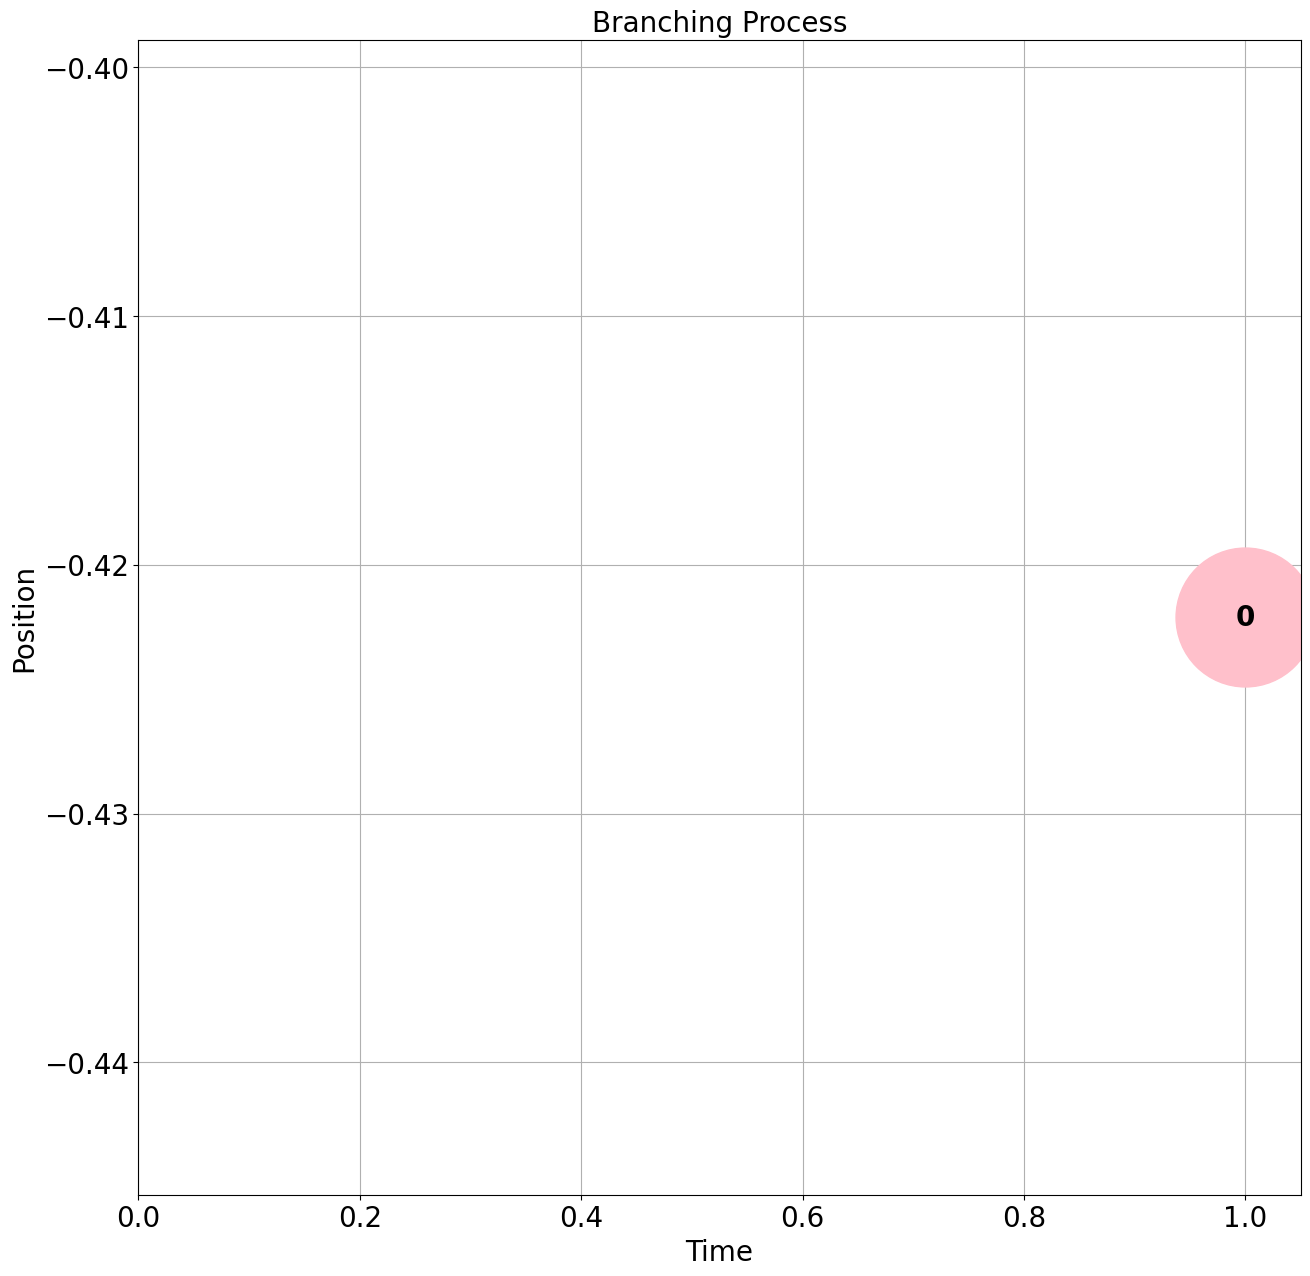

In [7]:
lambd = 1
result = BranchingProcess(1,lambd,[1/4]*4)
result(t=1, x=torch.zeros((1,1)))

# Crear el grafo
G = nx.DiGraph()

# Añadir nodos y aristas al grafo
color_map = []
for i, part in enumerate(result.parts):
    if result.total_time_parts[i]==1:
        color_map.append('pink')
    else:
        color_map.append('skyblue')
    if len(part) > 1:

        G.add_node(i, time=result.total_time_parts[i], pos = result.pos_parts[i].item(), label=str(tuple(part)))
        parent_index = result.parts.index(part[:-1])
        G.add_edge(parent_index, i)
    else:
        G.add_node(i, time=result.total_time_parts[i], pos = result.pos_parts[i].item(), label=str(0))

# Determinar las posiciones de los nodos en el gráfico
pos = {}
for node in G.nodes:
    time = G.nodes[node]['time']
    poss = G.nodes[node]['pos']
    pos[node] = (time, poss)  # Usamos el índice del nodo para el eje y

# Dibujar el grafo
#plt.figure(figsize=(14, 10))
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(G, pos, labels=nx.get_node_attributes(G, 'label'), with_labels=True, node_size=10000, node_color=color_map, font_size=20, font_weight="bold", edge_color="gray", ax = ax)

# Ajustar los límites del eje x para que todos los tiempos sean visibles
times = sorted(set(result.total_time_parts))
ax.set_xlim(0, max(times)+0.05)  # Asegúrate de que los tiempos se ajusten al gráfico

# Añadir el eje de los tiempos
ax.set_xlabel('Time', fontsize = 20)
ax.set_ylabel('Position',fontsize = 20)
ax.set_title('Branching Process', fontsize = 20)

# Añadir marcas y etiquetas del eje x
#ax.set_xticks(times, [f'{t:.2f}' for t in times])
limits=plt.axis('on') # turns on axis
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.tick_params(axis='x',labelsize = 20)
ax.tick_params(axis='y',labelsize = 20)

# Mostrar la cuadrícula y los ejes
ax.grid(True)
plt.show()


In [8]:
f1 = lambda y: -12/(9+2*torch.sum(y,dim=1)**2)
f2 = lambda y: -48*np.sqrt(y.size(1)+1)*torch.sum(y,dim=1)/(2*torch.sum(y,dim=1)**2+9)**2
lapf1 = lambda y: 144*y.size(1)*(3-2*torch.sum(y,dim=1)**2)/(9+2*torch.sum(y,dim=1)**2)**3
u = lambda s,y: -12/(9+2*(np.sqrt(y.size(1)+1)*s - torch.sum(y,dim=1))**2)

c0 = lambda s,y: f1(y) ** 3 + f1(y) ** 2 - lapf1(y)
c1 = lambda s,y: 3 * f1(y) ** 2 + 2 * f1(y)
c2 = lambda s,y: 3 * f1(y) + 1
c3 = lambda s,y: 1
c = [c0,c1,c2,c3]

In [25]:
d = 2
model1 = Model(f1,f2,c,d=2,lambd=1,dens_descendant = [1/4]*4,n_layers = 4, wide = 20, lr=1e-3,
              iters = 2000, M = 500, size_train = 1024, size_batch = 64,a=-3,b=3, t = .1)
model2 = Model(f1,f2,c,d=2,lambd=1,dens_descendant = [1/4]*4,n_layers = 4, wide = 20, lr=1e-3,
              iters = 2000, M = 500, size_train = 1024, size_batch = 64, a = -3, b = 3, t = 1)
#model3 = Model(f1,f2,c,d=2,lambd=1,dens_descendant = [1/4]*4,n_layers = 4, wide = 20, lr=1e-3,
#              iters = 2000, M = 500, size_train = 2048, size_batch = 64, a = -6, b = 6, t = 1)

In [26]:
model1.calc_loss()#,model2.calc_loss()#,model3.calc_loss()

tensor(1.1525, grad_fn=<MeanBackward0>)

In [27]:
model1.train()

Iterations 100 || loss: 0.1011
Iterations 200 || loss: 0.0084
Iterations 300 || loss: 0.0021
Iterations 400 || loss: 0.0010
Iterations 500 || loss: 0.0006
Iterations 600 || loss: 0.0004
Iterations 700 || loss: 0.0003
Iterations 800 || loss: 0.0003
Iterations 900 || loss: 0.0003
Iterations 1000 || loss: 0.0003
Iterations 1100 || loss: 0.0002
Iterations 1200 || loss: 0.0002
Iterations 1300 || loss: 0.0001
Iterations 1400 || loss: 0.0001
Iterations 1500 || loss: 0.0001
Iterations 1600 || loss: 0.0001
Iterations 1700 || loss: 0.0001
Iterations 1800 || loss: 0.0001
Iterations 1900 || loss: 0.0001
Iterations 2000 || loss: 0.0001
Elapsed Time= 0.634697 [s]


In [28]:
model2.train()

Iterations 100 || loss: 0.0921
Iterations 200 || loss: 0.0241
Iterations 300 || loss: 0.0230
Iterations 400 || loss: 0.0197
Iterations 500 || loss: 0.0098
Iterations 600 || loss: 0.0208
Iterations 700 || loss: 0.0049
Iterations 800 || loss: 0.0141
Iterations 900 || loss: 0.0110
Iterations 1000 || loss: 0.0117
Iterations 1100 || loss: 0.0072
Iterations 1200 || loss: 0.0064
Iterations 1300 || loss: 0.0169
Iterations 1400 || loss: 0.0165
Iterations 1500 || loss: 0.0120
Iterations 1600 || loss: 0.0115
Iterations 1700 || loss: 0.0148
Iterations 1800 || loss: 0.0060
Iterations 1900 || loss: 0.0094
Iterations 2000 || loss: 0.0101
Elapsed Time= 0.623138 [s]


In [29]:
#model3.train()

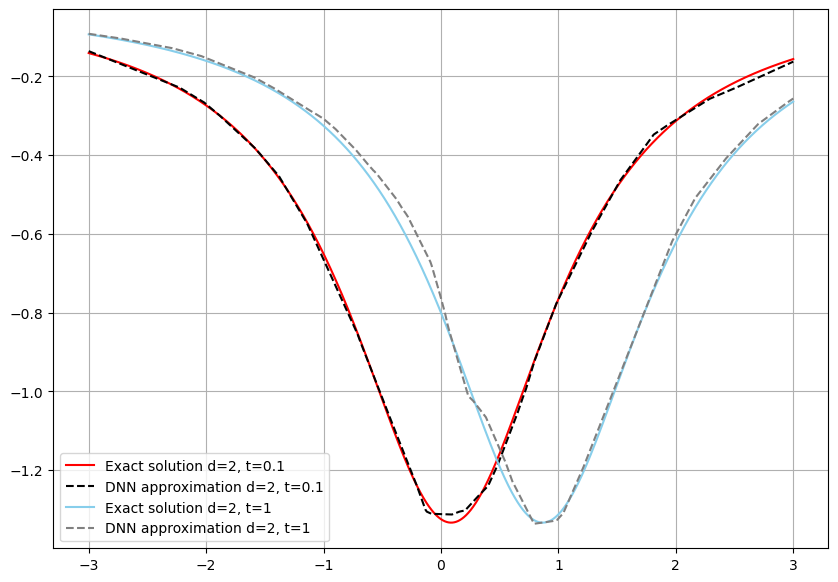

In [30]:
%matplotlib inline
N_test = 20000
xes = torch.linspace(model1.a,model1.b,N_test)
xes1 = torch.stack([xes]*model1.d,dim=1)
xes2 = torch.stack([xes]*model2.d,dim=1)
#xes3 = torch.stack([xes]*model3.d,dim=1)
y1 = u(model1.t,xes1)
y2 = u(model2.t,xes2)
#y3 = u(model3.t,xes3)
y_nn1= model1.net(xes1)
y_nn2= model2.net(xes2)
#y_nn3= model3.net(xes3)
#y_mc1=torch.stack([model1.MC(xes1[i,:],model1.M) for i in range(xes1.size(0))])+model1.f1(xes1).view((xes1.size(0),1))
#y_mc2=torch.stack([model2.MC(xes2[i,:],model2.M) for i in range(xes2.size(0))])+model2.f1(xes2).view((xes2.size(0),1))
#y_mc3=torch.stack([model3.MC(xes3[i,:],model3.M) for i in range(xes3.size(0))])+model3.f1(xes3).view((xes3.size(0),1))
plt.figure(figsize=(10,7))
plt.plot(xes1[:,0],y1,'red',label = 'Exact solution d=' +str(model1.d)+', t='+str(model1.t))
plt.plot(xes1[:,0],y_nn1.detach(),'--',color='black', label = 'DNN approximation d=' +str(model1.d)+', t='+str(model1.t))
#plt.plot(xes1[:,0],y_mc1.detach(),'--',color='blue', label = 'MC approximation d=' +str(model1.d)+', t='+str(model1.t))
plt.plot(xes2[:,0],y2,'skyblue',label = 'Exact solution d=' +str(model2.d)+', t='+str(model2.t))
plt.plot(xes2[:,0],y_nn2.detach(),'--',color='grey', label = 'DNN approximation d=' +str(model2.d)+', t='+str(model2.t))
#plt.plot(xes2[:,0],y_mc2.detach(),'--',color='blue', label = 'MC approximation d=' +str(model2.d)+', t='+str(model2.t))
#plt.plot(xes3[:,0],y3,'yellowgreen',label = 'Exact solution d=' +str(model3.d)+', t='+str(model3.t))
#plt.plot(xes3[:,0],y_nn3.detach(),'--',color='indigo', label = 'DNN approximation d=' +str(model3.d)+', t='+str(model3.t))
#plt.plot(xes3[:,0],y_mc3.detach(),'--',color='blue', label = 'MC approximation d=' +str(model3.d)+', t='+str(model3.t))
plt.grid()
plt.legend(loc = 'best')
plt.show()

In [31]:
model1.time_gen_data.total_seconds(),model2.time_gen_data.total_seconds()#,model3.time_gen_data.total_seconds()

(32.476769, 91.141676)

In [32]:
def Comparison3D(model):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # Data for a three-dimensional line
    xline = np.linspace(model.a, model.b, 1000)
    yline = np.linspace(model.a, model.b, 1000)
    X, Y = np.meshgrid(xline, yline)
    positions = np.column_stack([*[X.ravel()]*(model.d-1), Y.ravel()])
    U1 = model.net(torch.Tensor(positions))
    U1 = U1.view((len(xline),len(yline)))
    surf = ax.plot_surface(X, Y, U1.detach(), cmap='viridis',
                          linewidth=0, antialiased=False)
    ax.set_title('DNN solution for d = ' + str(model.d) +' and t = '+str(model.t))
    if model.d == 2:
        ax.set_xlabel('$x_1$')
    elif model.d == 3:
        ax.set_xlabel('$x_1=x_2$')
    ax.set_ylabel('$x_{'+str(model.d)+'}$')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    U2 = u(model.t,torch.Tensor(positions))
    U2 = U2.view((len(xline),len(yline)))
    surf = ax.plot_surface(X, Y, U2.detach(), cmap='viridis',
                          linewidth=0, antialiased=False)
    ax.set_title('Exact solution for d = ' + str(model.d) +' and t = '+str(model.t))
    if model.d == 2:
        ax.set_xlabel('$x_1$')
    elif model.d == 3:
        ax.set_xlabel('$x_1=x_2$')
    ax.set_ylabel('$x_{'+str(model.d)+'}$')
    plt.show()
    
def Difference3D(model):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    # Data for a three-dimensional line
    xline = np.linspace(model.a, model.b, 1000)
    yline = np.linspace(model.a, model.b, 1000)
    X, Y = np.meshgrid(xline, yline)
    positions = np.column_stack([*[X.ravel()]*(model.d-1), Y.ravel()])
    U1 = model.net(torch.Tensor(positions))
    U1 = U1.view((len(xline),len(yline)))
    U2 = u(model.t,torch.Tensor(positions))
    U2 = U2.view((len(xline),len(yline)))
    surf = ax.plot_surface(X, Y, torch.abs(U1-U2).detach(), cmap='viridis',
                          linewidth=0, antialiased=False)
    ax.set_title('Exact solution for d = ' + str(model.d) +' and t = '+str(model.t))
    if model.d == 2:
        ax.set_xlabel('$x_1$')
    elif model.d == 3:
        ax.set_xlabel('$x_1=x_2$')
    ax.set_ylabel('$x_{'+str(model.d)+'}$')
    plt.show()
    
def Linfty_norm(model):

    # Data for a three-dimensional line
    xline = np.linspace(model.a, model.b, 1000)
    yline = np.linspace(model.a, model.b, 1000)
    X, Y = np.meshgrid(xline, yline)
    positions = np.column_stack([*[X.ravel()]*(model.d-1), Y.ravel()])
    U1 = model.net(torch.Tensor(positions))
    U1 = U1.view((len(xline),len(yline)))
    U2 = u(model.t,torch.Tensor(positions))
    U2 = U2.view((len(xline),len(yline)))
    difference = torch.abs(U1-U2)
    return torch.max(difference)
        

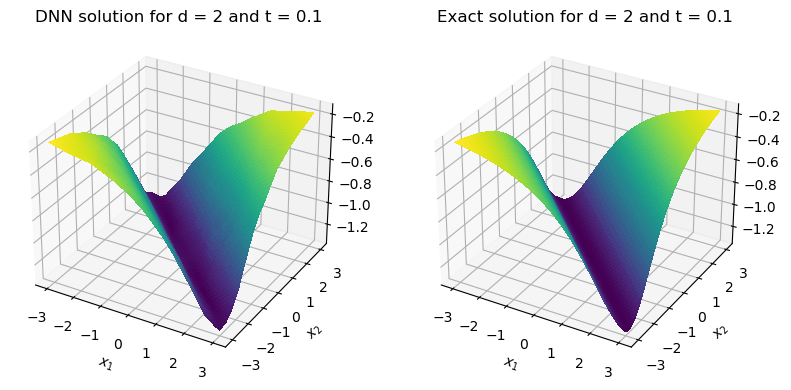

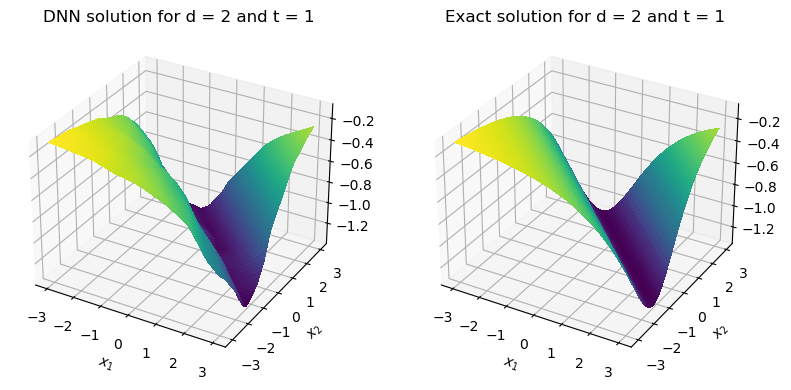

In [33]:
#%matplotlib notebook
%matplotlib inline
Comparison3D(model1)
Comparison3D(model2)
#Comparison3D(model3)

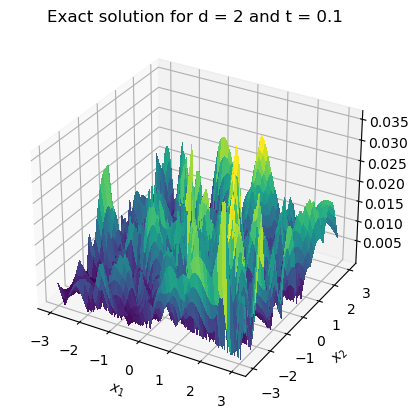

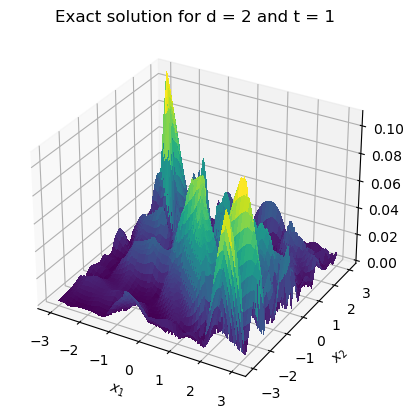

NameError: name 'model3' is not defined

In [34]:
Difference3D(model1)
Difference3D(model2)
Difference3D(model3)

In [35]:
Linfty_norm(model1),Linfty_norm(model2)#,Linfty_norm(model3)

(tensor(0.0363, grad_fn=<MaxBackward1>),
 tensor(0.1086, grad_fn=<MaxBackward1>))

In [36]:
n_test = int(1e6)
test_data = model1.a + (model1.b - model1.a)*torch.rand((n_test,model1.d))

def Absolute_Error(model,data):
    U1 = model.net(data)
    U2 = u(model.t,data).view((len(data),1))
    diff = torch.abs(U1-U2)
    aux = diff/torch.abs(U2)
    #diff2 = torch.pow(diff,2)
    return aux.mean()

In [37]:
Absolute_Error(model1,test_data),Absolute_Error(model2,test_data)#,Absolute_Error(model3,test_data)

(tensor(0.0116, grad_fn=<MeanBackward0>),
 tensor(0.0306, grad_fn=<MeanBackward0>))